<img src=../images/cdcrbanner.png width=1000 margin=0px>

---

# Namespaces (Enterprise Feature)
---

## Business Value of Capability
When Vault is primarily used as a central location to manage secrets, multiple organizations within a company may need to be able to manage their secrets in a self-serving manner. This means that a company needs to implement a Vault as a Service model allowing each organization (tenant) to manage their own secrets and policies. Most importantly, tenants should be restricted to work only within their tenant scope.

<img src=attachment:92e56b84-c585-4d07-9465-282f815c5c58.png width=1000>
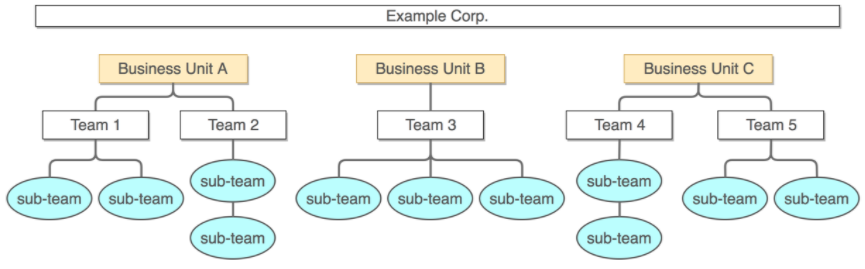

### Setup
---

In [ ]:
unset VAULT_NAMESPACE
export VAULT_ADDR=http://127.0.0.1:8200
export VAULT_TOKEN=root
export VAULT_SKIP_VERIFY=true
export LICENSE=/Users/jnyika/.licenses/vault.json

In [ ]:
vault login root

In [ ]:
vault status

In [ ]:
vault -version

In [ ]:
#license
curl \
  --header "X-Vault-Token: root" \
  --request PUT \
  --data "@${LICENSE}" \
  http://127.0.0.1:8200/v1/sys/license

### Demo
---

### Step 1: Create namespaces  
(Persona: Operations)

In [ ]:
vault namespace create education

In [ ]:
vault namespace create -namespace=education training

In [ ]:
vault namespace create -namespace=education certification

**View namespaces**  

In [ ]:
vault namespace list

In [ ]:
vault namespace list -namespace=education

### Step 2: Write policies
(Persona: Operations)

In [ ]:
cat << EOF > ./config/edu-admin.hcl
# Manage namespaces
path "sys/namespaces/*" {
   capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# Manage policies
path "sys/policies/acl/*" {
   capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# List policies
path "sys/policies/acl" {
   capabilities = ["list"]
}

# Enable and manage secrets engines
path "sys/mounts/*" {
   capabilities = ["create", "read", "update", "delete", "list"]
}

# List available secrets engines
path "sys/mounts" {
  capabilities = [ "read" ]
}

# Create and manage entities and groups
path "identity/*" {
   capabilities = ["create", "read", "update", "delete", "list"]
}

# Manage tokens
path "auth/token/*" {
   capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# Manage secrets at 'edu-secret'
path "edu-secret/*" {
   capabilities = ["create", "read", "update", "delete", "list"]
}
EOF

In [ ]:
cat << EOF > ./config/training-admin.hcl
# Manage namespaces
path "sys/namespaces/*" {
   capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# Manage policies
path "sys/policies/acl/*" {
   capabilities = ["create", "read", "update", "delete", "list", "sudo"]
}

# List policies
path "sys/policies/acl" {
  capabilities = ["list"]
}

# Enable and manage secrets engines
path "sys/mounts/*" {
   capabilities = ["create", "read", "update", "delete", "list"]
}

# List available secrets engines
path "sys/mounts" {
  capabilities = [ "read" ]
}

# Manage secrets at 'team-secret'
path "team-secret/*" {
   capabilities = ["create", "read", "update", "delete", "list"]
}
EOF

**Deploy policies**  
(Persona: Operations)

In [ ]:
vault policy write -namespace=education edu-admin ./config/edu-admin.hcl

In [ ]:
vault policy write -namespace=education/training training-admin ./config/training-admin.hcl

### Step 3: Setup entities and groups**
(Persona: Operations)

**Enable userpass auth method, create user, entity, mount, entity alias, and group**

In [ ]:
vault auth enable -namespace=education userpass
vault write -namespace=education auth/userpass/users/bob password="training"
vault write -namespace=education -format=json identity/entity name="Bob Smith" policies="edu-admin" | jq -r ".data.id" > entity_id.txt
vault auth list -namespace=education -format=json | jq -r '.["userpass/"].accessor' > accessor.txt
vault write -namespace=education identity/entity-alias name="bob" canonical_id=$(cat entity_id.txt) mount_accessor=$(cat accessor.txt)
vault write -namespace=education/training identity/group name="Training Admin" policies="training-admin" member_entity_ids=$(cat entity_id.txt)


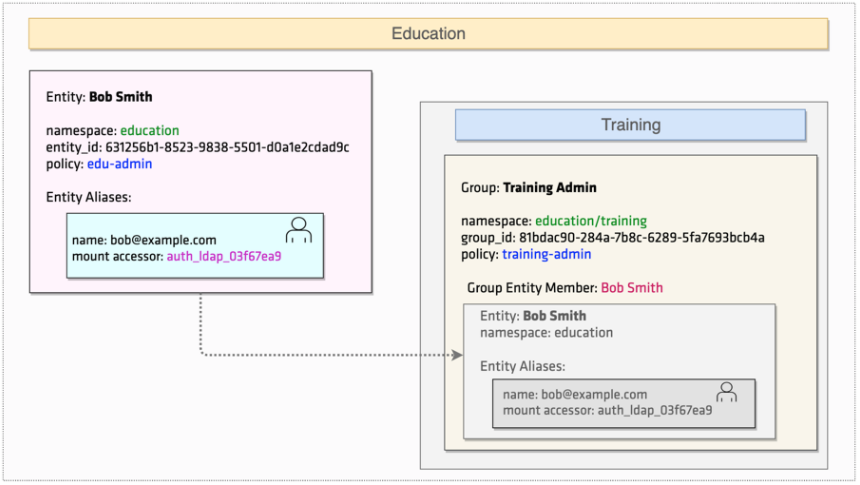

### Step 4: Test the Bob Smith entity
(Persona: org-admin)

**Log in as `bob` into the `education` namespace**

In [ ]:
vault login -namespace=education -method=userpass username="bob" password="training"

Notice that the generated token contains the namespace ID which was created. User `bob` only has `default` policy attached to h is token, however, he inherited the `edu-admin` policy from the `Bob Smith` entity.

**Test that `bob` can create a namespace, enable secrets engine, etc. against the `education` namespace**

In [ ]:
export VAULT_NAMESPACE="education"
vault namespace create web-app


In [ ]:
vault secrets enable -path=edu-secret kv-v2

In [ ]:
unset VAULT_NAMESPACE

### Step 5: Test the Training Admin group

In [ ]:
vault token lookup

Notice that the `external_namespace_policies` parameter lists `training-admin policy`. The user `bob` inherited this policy from the `Training Admin` group defined in the `education/training` namespace although `bob` user was created in the `education` namespace.

**Verify that `bob` can perform the operations permitted by the `training-admin` policy**

In [ ]:
export VAULT_NAMESPACE="education/training"
vault namespace create vault-training

In [ ]:
vault secrets enable -path=team-secret -version=1 kv

As we demonstrated, each namespace you created behaves as an **isolated** Vault environment. By default, there is no visibility into other namespaces regardless of its hierarchical relationship. In order for Bob to operate in `education/training namespace`, you can enable an auth method in the `education/training` namespace so that he can log in. Or, as demonstrated, you can use Vault identity to associate entities and groups defined in different namespaces.

**END**